# 3. Streaming application using Spark Structured Streaming (60%) In this task, we will implement Spark Structured Streaming to consume the data from task 1                and perform predictive analytics. 
 Important​:  - In this task, use Spark Structured Streaming together with Spark SQL and ML - You are also provided with a set of pre-trained pipeline models, one for             predicting attack in process data, another for predicting attack in memory data 
 
Write a python program that achieves the following requirements. Save the file as Assignment-2B-Task3_streaming_application.ipynb. 


1. SparkSession is created using a SparkConf object, which would use two local cores             with a proper application name, and use UTC as the timezone​3​ (4%) 

In [1]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-streaming-kafka-0-10_2.12:3.0.0,org.apache.spark:spark-sql-kafka-0-10_2.12:3.0.0 pyspark-shell'
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *
import time
from pyspark.ml import PipelineModel

conf = SparkConf()\
    .setAppName("Task3_streaming_application") \
    .setMaster("local[2]") \
    .set("spark.sql.session.timeZone", "UTC")
spark = SparkSession \
    .builder \
    .config(conf=conf)\
    .getOrCreate()

2. From the Kafka producers in Task 1.1 and 1.2, ingest the streaming data into Spark               Streaming  for both process and memory activities(3%) 

In [2]:
df_process = spark \
    .readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "127.0.0.1:9092") \
    .option("subscribe", "Streaming_Linux_process") \
    .load()

In [3]:
df_memory = spark \
    .readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "127.0.0.1:9092") \
    .option("subscribe", "Streaming_Linux_memory") \
    .load()

3. Then the streaming data format should be transformed into the proper formats            following the metadata file schema for both process and memory, similar to            assignment 2A​4​ (3%) - The numeric values with extra spaces or “K” / “M” / “G” should be properly               transformed into their correct values - The NICE value should also be restored based on the PRI values using their              relationship​5 - Hint - There is a mapping between PRI (priority) and NICE, as long as              the process is not yet finished during the last interval. For example,  - PRI  100  maps to NICE -20 - PRI 101 maps toNICE -19 - … - PRI 139 maps to NICE 19 - Hint - If the process is finished, PRI and NICE would both be 0. 

In [4]:
df_process = df_process.selectExpr("CAST(key AS STRING)", "CAST(value AS STRING)")

In [5]:
df_process.printSchema()

root
 |-- key: string (nullable = true)
 |-- value: string (nullable = true)



In [6]:
schema_process = ArrayType(StructType([    
    StructField('sequence', StringType(), True), 
    StructField('machine', StringType(), True),
    StructField('PID', StringType(), True),
    StructField('TRUN', StringType(), True),
    StructField('TSLPI', StringType(), True), 
    StructField('TSLPU', StringType(), True),
    StructField('POLI', StringType(), True),
    StructField('NICE', StringType(), True), 
    StructField('PRI', StringType(), True),
    StructField('RTPR', StringType(), True),
    StructField('CPUNR', StringType(), True), 
    StructField('Status', StringType(), True),
    StructField('EXC', StringType(), True),
    StructField('State', StringType(), True), 
    StructField('CPU', StringType(), True),
    StructField('CMD', StringType(), True),
    StructField('ts', StringType(), True)
]))

In [7]:
df_process = df_process.select(F.from_json(F.col("value"), schema_process).alias("parsed_value"))


In [8]:
df_process = df_process.select(F.explode(F.col("parsed_value")).alias("value"))

In [9]:
df_process = df_process.select(F.col("value.sequence").cast(IntegerType()).alias("sequence"),
                    F.col("value.machine").cast(IntegerType()).alias("machine"),
                    F.col("value.PID").cast(IntegerType()).alias("PID"),
                    F.col("value.TRUN").cast(IntegerType()).alias("TRUN"),
                    F.col("value.TSLPI").cast(IntegerType()).alias("TSLPI"),
                    F.col("value.TSLPU").cast(IntegerType()).alias("TSLPU"),
                    F.col("value.POLI").cast(StringType()).alias("POLI"),
                    F.col("value.NICE").cast(IntegerType()).alias("NICE"),
                    F.col("value.PRI").cast(IntegerType()).alias("PRI"),
                    F.col("value.RTPR").cast(IntegerType()).alias("RTPR"),
                    F.col("value.CPUNR").cast(IntegerType()).alias("CPUNR"),
                    F.col("value.Status").cast( StringType()).alias("Status"),
                    F.col("value.EXC").cast(IntegerType()).alias("EXC"),
                    F.col("value.State").cast(StringType()).alias("State"),
                    F.col("value.CPU").cast(DoubleType()).alias("CPU"),
                    F.col("value.CMD").cast(StringType()).alias("CMD"),
                    F.col("value.ts").cast(IntegerType()).alias("ts"))

In [10]:
df_process.printSchema()

root
 |-- sequence: integer (nullable = true)
 |-- machine: integer (nullable = true)
 |-- PID: integer (nullable = true)
 |-- TRUN: integer (nullable = true)
 |-- TSLPI: integer (nullable = true)
 |-- TSLPU: integer (nullable = true)
 |-- POLI: string (nullable = true)
 |-- NICE: integer (nullable = true)
 |-- PRI: integer (nullable = true)
 |-- RTPR: integer (nullable = true)
 |-- CPUNR: integer (nullable = true)
 |-- Status: string (nullable = true)
 |-- EXC: integer (nullable = true)
 |-- State: string (nullable = true)
 |-- CPU: double (nullable = true)
 |-- CMD: string (nullable = true)
 |-- ts: integer (nullable = true)



In [11]:
df_memory = df_memory.selectExpr("CAST(key AS STRING)", "CAST(value AS STRING)")

In [12]:
schema_memory = ArrayType(StructType([    
    StructField('sequence', StringType(), True), 
    StructField('machine', StringType(), True),
    StructField('PID', StringType(), True),
    StructField('MINFLT', StringType(), True),
    StructField('MAJFLT', StringType(), True), 
    StructField('VSTEXT', StringType(), True),
    StructField('VSIZE', StringType(), True),
    StructField('RSIZE', StringType(), True), 
    StructField('VGROW', StringType(), True),
    StructField('RGROW', StringType(), True),
    StructField('MEM', StringType(), True), 
    StructField('CMD', StringType(), True),
    StructField('ts', StringType(), True)
]))

In [13]:
df_memory = df_memory.select(F.from_json(F.col("value"), schema_memory).alias('parsed_value'))
df_memory = df_memory.select(F.explode(F.col("parsed_value")).alias('value'))
df_memory = df_memory.select(
                    F.col("value.sequence").cast(IntegerType()).alias("sequence"),
                    F.col("value.machine").cast(IntegerType()).alias("machine"),
                    F.col("value.PID").cast(IntegerType()).alias("PID"),
                    F.col("value.MINFLT").alias("MINFLT"),
                    F.col("value.MAJFLT").alias("MAJFLT"),
                    F.col("value.VSTEXT").alias("VSTEXT"),
                    F.col("value.VSIZE").cast(DoubleType()).alias("VSIZE"),
                    F.col("value.RSIZE").alias("RSIZE"),
                    F.col("value.VGROW").alias("VGROW"),
                    F.col("value.RGROW").alias("RGROW"),
                    F.col("value.MEM").cast(DoubleType()).alias("MEM"),
                    F.col("value.CMD").alias("CMD"),
                    F.col("value.ts").cast(IntegerType()).alias("ts")
                )
df_memory.printSchema()

root
 |-- sequence: integer (nullable = true)
 |-- machine: integer (nullable = true)
 |-- PID: integer (nullable = true)
 |-- MINFLT: string (nullable = true)
 |-- MAJFLT: string (nullable = true)
 |-- VSTEXT: string (nullable = true)
 |-- VSIZE: double (nullable = true)
 |-- RSIZE: string (nullable = true)
 |-- VGROW: string (nullable = true)
 |-- RGROW: string (nullable = true)
 |-- MEM: double (nullable = true)
 |-- CMD: string (nullable = true)
 |-- ts: integer (nullable = true)



In [14]:
from pyspark.sql.functions import udf

@udf(StringType())
def convert_character(data):
    data =data.replace(' ','')
    if data[-1]=='K':
        data = float(data[:-2]) * 1000*1000*1000
        data = int(data)
    elif data[-1]=='M':
        data = float(data[:-2]) * 1000*1000
        data = int(data)
    elif data[-1]=='G':
        data = float(data[:-2]) * 1000
        data = int(data)
    return data


In [15]:
df_memory = df_memory.withColumn("MINFLT", convert_character("MINFLT").cast(IntegerType()))
df_memory = df_memory.withColumn("MAJFLT", convert_character("MAJFLT").cast(IntegerType()))
df_memory = df_memory.withColumn("VSTEXT", convert_character("VSTEXT").cast(DoubleType()))
df_memory = df_memory.withColumn("RSIZE", convert_character("RSIZE").cast(DoubleType()))
df_memory = df_memory.withColumn("VGROW", convert_character("VGROW").cast(DoubleType()))
df_memory = df_memory.withColumn("RGROW", convert_character("RGROW").cast(DoubleType()))

In [16]:
df_process = df_process.withColumn("NICE", F.when(F.col("PRI")==0, 0).otherwise(F.col("PRI")-120))

4.For process and memory, respectively, create a new column “CMD_PID”          concatenating “CMD” and “PID” columns, and a new column “event_time” as           timestamp format based on the unix time in “ts” column (5%)
 Allow 20-second tolerance for possible data delay on “event_time” using          watermarking

In [17]:
df_process = df_process.withColumn("CMD_PID",F.concat(F.col("CMD"),F.lit("_"),F.col("PID")))

In [18]:
df_memory = df_memory.withColumn("CMD_PID",F.concat(F.col("CMD"),F.lit("_"),F.col("PID")))

In [19]:
df_process = df_process.withColumn("event_time", F.col('ts').cast(TimestampType()))\
    .withWatermark("event_time","20 seconds")

In [20]:
df_process.printSchema()

root
 |-- sequence: integer (nullable = true)
 |-- machine: integer (nullable = true)
 |-- PID: integer (nullable = true)
 |-- TRUN: integer (nullable = true)
 |-- TSLPI: integer (nullable = true)
 |-- TSLPU: integer (nullable = true)
 |-- POLI: string (nullable = true)
 |-- NICE: integer (nullable = true)
 |-- PRI: integer (nullable = true)
 |-- RTPR: integer (nullable = true)
 |-- CPUNR: integer (nullable = true)
 |-- Status: string (nullable = true)
 |-- EXC: integer (nullable = true)
 |-- State: string (nullable = true)
 |-- CPU: double (nullable = true)
 |-- CMD: string (nullable = true)
 |-- ts: integer (nullable = true)
 |-- CMD_PID: string (nullable = true)
 |-- event_time: timestamp (nullable = true)



In [21]:
df_memory = df_memory.withColumn("event_time", F.col('ts').cast(TimestampType())).withWatermark("event_time","20 seconds")

5. Persist the transformed streaming data in parquet format for both process and            memory (5%) - The process data should be stored in “process.parquet” in the same folder of             your notebook, and the memory data should be stored in “memory.parquet” in            the same folder of your notebook 
 

In [22]:
query_process_save = df_process.writeStream.format("parquet")\
        .outputMode("append")\
        .option("path", "process.parquet")\
        .option("checkpointLocation", "process.parquet/checkpoint")\
        .start()

In [23]:
query_process_save.stop()

In [24]:
query_memory_save = df_memory.writeStream.format("parquet")\
        .outputMode("append")\
        .option("path", "memory.parquet")\
        .option("checkpointLocation", "memory.parquet/checkpoint")\
        .start()

In [25]:
query_memory_save.stop()

6. Load the machine learning models given​6​, and use the models to predict whether             each process or memory streaming record is an attack event, respectively (5%) 

In [26]:
memory_pipeline = PipelineModel.load("./memory_pipeline_model")
process_pipeline = PipelineModel.load("./process_pipeline_model")

In [27]:
memory_prediction = memory_pipeline.transform(df_memory)
process_prediction = process_pipeline.transform(df_process)

7. Using the prediction result, and monitor the data following the requirements below            (30%) a. If any program in one machine is predicted as an attack in ​EITHER process              or memory activity prediction, it could be a false alarm or a potential attack.              Keep track of the approximate count of such events ​in every 2-minwindow             for each machine for process and memory, respectively, and write the stream            into Spark Memory sink using complete mode​7  - Your aggregated result should include machine ID, the time window,          and the counts - Note that if there are more than one entries having the SAME            “CMD_PID” in a 2-min window, get the approximate distinct count - For example, if two or more records of “atop” program with the            exact same “CMD_PID” are predicted as an attack in the          process between 2020-10-10 10:10:10 and 2020-10-10      10:11:09​ , only need to count this “atop” program attack once.

In [28]:
memory_resault = memory_prediction.select("machine","CMD_PID", "event_time","prediction")
process_resault  = process_prediction.select("machine","CMD_PID","event_time","prediction")
prediction_m_p = memory_resault.union(process_resault)
prediction_m_p=prediction_m_p.filter(F.col("prediction")==1)\
    .groupby("machine",F.window('event_time','2 minute'))\
    .agg(F.approx_count_distinct("CMD_PID").alias("count"))


In [29]:
query = prediction_m_p.writeStream\
                .outputMode("complete")\
                .format("memory")\
                .queryName("prediction")\
                .trigger(processingTime="5 seconds")\
                .start()

In [74]:
query.stop()

    b. If a program in one machine, having the same “CMD” and “PID” in both process and memory streaming data, is predicted as an attack in ​BOTH process and memory activity prediction, then this is considered as an attack event. Find the streaming events fulfilling the criteria, create a new column to record the processing time​8​ and persist them in parquet. - Note the program with the same “CMD” and “PID” might not be generated at the exact same event time. If the difference between the event times in process and memory is less than 30 seconds and the program fulfills the criteria of matching “CMD” and “PID”, then you should include them for the above checking.  - If there are multiple entries fulfilling the above criteria in process or memory, do not remove the extra entries  - Persist the program’s relevant information (including process & memory data, process & memory’s event and processing timestamp,and prediction result) into parquet format with the name of“process_memory_attack.parquet” 

In [30]:
prediction_all = memory_prediction\
    .join(process_prediction,memory_prediction.CMD_PID == process_prediction.CMD_PID)\
    .filter(process_prediction.prediction==1)\
    .filter(memory_prediction.prediction==1)\
    .filter(F.abs(process_prediction.event_time.cast(LongType())- memory_prediction.event_time.cast(LongType())) <30)


In [31]:
prediction_all = prediction_all.withColumn("processing_time", F.current_timestamp())

In [32]:
prediction_all_attack = prediction_all.select("*")


In [33]:
query_all = prediction_all_attack.writeStream\
                .outputMode("append")\
                .format("memory")\
                .queryName("prediction_all")\
                .trigger(processingTime="5 seconds")\
                .start()


In [34]:
query_all.stop()

In [35]:
query_save_prediction = prediction_all.writeStream\
                .format("parquet")\
                .option("path","process_memory_attack.parquet")\
                .option("checkpointLocation","process_memory_attack.parquet/checkpointt").start()

In [36]:
query_save_prediction.stop()

8. Visualise the data in line charts for step 7a (5%) 
 
 For the count of suspect attacks for each machine in step 7a, use Spark SQL               to query the data from Spark Memory sink, and prepare a line chart plot for               showing the count of suspect attacks for each machine at each 2-min window             from the start to the most recent, and refresh the plot every 10 minutes - Hint - x-axis can be used to represent the timeline, while y-axis can be              used to represent the count; each machine’s line data can be           represented in different color legends 
 
 

In [158]:
def init_plots():
    try:
        width = 15
        height = 5
        fig = plt.figure(figsize=(width,height)) # create new figure
        ax = fig.add_subplot(111) # adding the subplot axes to the given grid position
        fig.suptitle('Real-time uniform stream data visualization') # giving figure a title
        ax.set_xlabel('Time')
        ax.set_ylabel('Value')        
        fig.show() # displaying the figure
        fig.canvas.draw() # drawing on the canvas
        return fig, ax
    except Exception as ex:
        print(str(ex))

In [118]:
def splitWindow(array, pos):
    return array[pos]

<IPython.core.display.Javascript object>


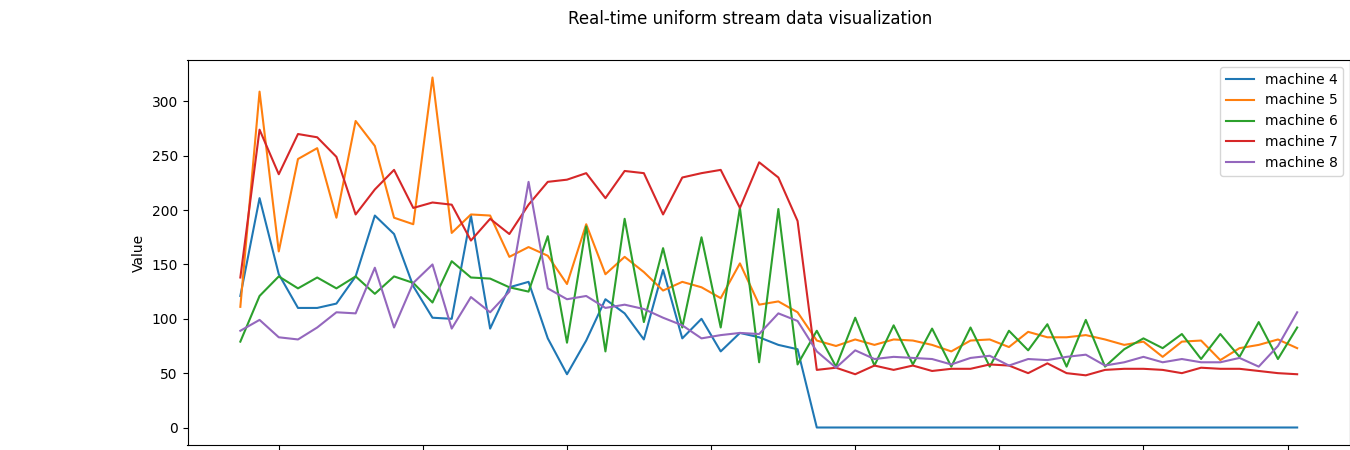

KeyboardInterrupt: 

In [173]:
import matplotlib.pylab as plt
%matplotlib notebook
fig,ax = init_plots()

while True:
    try:
        df = spark.sql("select * from prediction")
        df=df.withColumn('start',splitWindow(F.col('window'),'start'))
        machine4 = df.filter(col("machine")==4).orderBy('start').collect()
        machine5 = df.filter(col("machine")==5).orderBy('start').collect()
        machine6 = df.filter(col("machine")==6).orderBy('start').collect()
        machine7 = df.filter(col("machine")==7).orderBy('start').collect()
        machine8 = df.filter(col("machine")==8).orderBy('start').collect()
        x = []
        y= [[],[],[],[],[]]
        for i in machine4:
            if i['start'] not in x:
                x.append(i['start'])
            y[0].append(i['count'])
        for a in machine5:
            if a['start'] not in x:
                x.append(a['start'])
            y[1].append(a['count'])
        for b in machine6:
            if b['start'] not in x:
                x.append(b['start'])
            y[2].append(b['count'])
        for c in machine7:
            if c['start'] not in x:
                x.append(c['start'])
            y[3].append(c['count'])
        for d in machine8:
            if d['start'] not in x:
                x.append(d['start'])
            y[4].append(d['count'])
        for e in y:
            if len(e)<len(x):
                for f in range(0,(len(x)-len(e))):
                    e.append(0)
        ax.clear()
        ax.plot(x, y[0],label='machine 4')
        ax.plot(x, y[1],label='machine 5')
        ax.plot(x, y[2],label='machine 6')
        ax.plot(x, y[3],label='machine 7')
        ax.plot(x, y[4],label='machine 8')
        ax.set_xlabel('Time')
        ax.set_ylabel('Value')
        ax.legend()
        fig.canvas.draw()
        time.sleep(60*10)
    except Exception as ex:
        print(str(ex))